In [1]:
import glob
import os, sys, subprocess
import ROOT as rt
import re
import glob
import numpy as np
%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.18/02


In [2]:
np.random.randint(10)

4

In [17]:
data_DNN = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/DelayedPhoton_DoubleEG_2016All_GoodLumi.root'
data_noDNN = '/storage/user/qnguyen/DelayedPhoton/CMSSW_8_1_0/src/HiggsAnalysis/DelayedPhotonLimit/2016/skim_noBDT/DelayedPhoton_DoubleEG_2016All_GoodLumi.root'
signal_DNN = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/GMSB_L200TeV_Ctau200cm_13TeV-pythia8.root'
signal_noDNN = '/storage/user/qnguyen/DelayedPhoton/CMSSW_8_1_0/src/HiggsAnalysis/DelayedPhotonLimit/2016/skim_noBDT/GMSB_L200TeV_Ctau200cm_13TeV-pythia8.root'

filelist = [data_DNN, data_noDNN, signal_DNN, signal_noDNN]
legend_list = ['Data w/ DNN', 'Data w/o DNN', 'Signal w/ DNN', 'Signal w/o DNN']
lumi_2016 = 35922.0
lumi_2017 = 41530.0
lumi = lumi_2016

marker_size = 1

id_cut = ['pho1DNN > 0.2312']

sample_color = [rt.kBlack,
               rt.kRed,
               rt.kPink+9,
               rt.kMagenta+2,
               rt.kViolet+6,
               rt.kBlue,
               rt.kAzure,
               rt.kAzure+7,
               rt.kCyan+2,
               rt.kTeal-6,
               rt.kGreen+3,
               rt.kSpring+4,
               rt.kYellow-2]

sample_marker = [39, 41, 43, 45, 47, 48, 49, 21, 22, 23, 29, 33, 34]

def getXS(sample):
    with open("/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/data/all_bkg_back.list", "r") as xsfile:
        allxs = xsfile.readlines()
        for xs in allxs:
            if xs.split(' ')[0] in sample:
                return xs.split(' ')[-1].replace('\n','')
    print("[WARNING] {} cross section not found".format(sample))
    return 0

def extract_num(string):
    sample_num = list(map(int, re.findall(r'\d+', string.split('/')[-1])))
    if len(sample_num) > 1:
        sample_lambda, sample_ctau = sample_num[0], sample_num[1]
        if sample_ctau == 0:
            if "0_001cm" in string:
                sample_ctau = 0.001
            elif "0_01cm" in string:
                sample_ctau = 0.01
            elif "0_1cm" in string:
                sample_ctau = 0.1

        return sample_lambda, sample_ctau
    else:
        print("Can't extract number from {}".format(string))
        return 0, 0

def getSignalXS(sample):
    """Get cross section x BR for signal MC"""
    sample_lambda, sample_ctau = extract_num(sample)

    dat_file = "/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/data/XsecBR.dat"
    with open(dat_file, "r") as xsfile:
        allxs = xsfile.readlines()
        for xs in allxs[1:]:
            this_lambda, this_ctau = extract_num(xs)
            if sample_lambda == this_lambda and sample_ctau == this_ctau:
                return float(xs.split(' ')[4])
    print("[WARNING] {} cross section not found in {}".format(sample, dat_file))
    return 0


In [22]:
features = ['t1MET']
xranges = {'t1MET': (0, 500)}
useLogY = {'t1MET': False}

for pho_to_plot in [1, 2]:
    features.extend(['pho{}ecalPFClusterIso'.format(pho_to_plot), 
                'pho{}hcalPFClusterIso'.format(pho_to_plot),
                'pho{}trkSumPtHollowConeDR03'.format(pho_to_plot), 
                'pho{}R9'.format(pho_to_plot), 
                'pho{}SigmaIetaIeta'.format(pho_to_plot), 
                'pho{}Smajor'.format(pho_to_plot), 
                'pho{}Sminor'.format(pho_to_plot),
                'pho{}_genVtxZ'.format(pho_to_plot),
                'R{}'.format(pho_to_plot)])

    xranges.update({
               'pho{}ecalPFClusterIso'.format(pho_to_plot): (0,7),
               'pho{}hcalPFClusterIso'.format(pho_to_plot): (0, 5),
               'pho{}trkSumPtHollowConeDR03'.format(pho_to_plot): (0,7),
               'pho{}R9'.format(pho_to_plot): (0.9,1.),
               'pho{}SigmaIetaIeta'.format(pho_to_plot): (0, 0.02),
               'pho{}Smajor'.format(pho_to_plot): (0, 1.5),
               'pho{}Sminor'.format(pho_to_plot): (0., 0.7),
               'pho{}angle_xtal'.format(pho_to_plot): (0, 1.),
               'pho{}_genVtxZ'.format(pho_to_plot): (-1500, 1500),
               'R{}'.format(pho_to_plot): (0, 1000)
    })

    useLogY.update({
               'pho{}ecalPFClusterIso'.format(pho_to_plot): True,
               'pho{}hcalPFClusterIso'.format(pho_to_plot): True,
               'pho{}trkSumPtHollowConeDR03'.format(pho_to_plot): True,
               'pho{}R9'.format(pho_to_plot): False,
               'pho{}SigmaIetaIeta'.format(pho_to_plot): True,
               'pho{}Smajor'.format(pho_to_plot): True,
               'pho{}Sminor'.format(pho_to_plot): True,
               'pho{}angle_xtal'.format(pho_to_plot): True,
               'pho{}_genVtxZ'.format(pho_to_plot): True,
               'R{}'.format(pho_to_plot): True
    })


In [20]:
hist_list = {}
allsn_hist = {}

for fea in features:
    hist_list[fea] = []
    color_index = 0
    for sample in filelist:
        ### Get lambda and ctau 
        tmp_file = rt.TFile.Open(sample, "READ")
        tmp_tree = tmp_file.Get("DelayedPhoton")
        tmp_sw = tmp_file.Get("SumWeights")
        if 'GMSB' in sample:
            this_lambda, this_ctau = extract_num(sample)
            xs = getSignalXS(sample)
            sumWeights = tmp_sw.Integral()

        else:
            xs = 1.
            sumWeights = 1.
            
        hist_list[fea].append(rt.TH1F("hist[{}]_{}".format(fea, color_index), 
                                      "{}; {}".format(sample.split('/')[-1], fea), 100, 
                                      xranges[fea][0], xranges[fea][1]))

        event_cut = 'n_Jets > 2 && (HLTDecision[81] == 1) && \
                     n_Photons == 2 && \
                     abs(pho1ClusterTime_SmearToData) < 1.0'
        
        pho_cut = ' && pho1Pt > 50 && abs(pho1Eta)<1.4442 \
                    && abs(pho1HoverE) < 0.08 \
                    && pho1R9 > 0.9 && abs(pho1SigmaIetaIeta) < 0.020 \
                    && abs(pho1ecalPFClusterIso) < 7.0 \
                    && abs(pho1hcalPFClusterIso) < 5.0 \
                    && abs(pho1trkSumPtHollowConeDR03) < 7.0'

        met_cut = " && Flag_HBHENoiseFilter == 1 && Flag_HBHEIsoNoiseFilter ==1 && \
               Flag_goodVertices == 1 && Flag_eeBadScFilter == 1 && \
               Flag_EcalDeadCellTriggerPrimitiveFilter == 1 && \
               Flag_CSCTightHaloFilter == 1  && \
               Flag_badMuonFilter == 1 && Flag_badGlobalMuonFilter == 0 && \
               Flag_duplicateMuonFilter == 0 "
        
        xsecOverSumweights = float(xs)/sumWeights
        weight_selection = "({event_cut} {pho_cut}) * (weight * \
                            pileupWeight * {lumi} * {xsecOverSumweights})".format(event_cut=event_cut,
                                                                                pho_cut = pho_cut,
                                                                                met_cut=met_cut,
                                                                                lumi=lumi,
                                                                                xsecOverSumweights=xsecOverSumweights)
#                 weight_selection = "(HLTDecision[81] == 1) * (weight * \
#                                     pileupWeight * {lumi} * {xsecOverSumweights})".format(event_cut=event_cut,
#                                                                                         pho_cut = pho_cut,
#                                                                                         met_cut=met_cut,
#                                                                                         lumi=lumi,
#                                                                                         xsecOverSumweights=xsecOverSumweights)

        tmp_tree.Draw("{}>>hist[{}]_{}".format(fea, fea, color_index), weight_selection)
        hist_list[fea][-1].SetDirectory(0)
        print("{}\n\tWeighted sum events = {:.2f}\n\txs = {}\n\txs/sumWeight = {}".format(sample, 
                                                                   hist_list[fea][-1].Integral(),
                                                                   xs, xsecOverSumweights))
        hist_list[fea][-1].SetFillColor(sample_color[color_index])
        hist_list[fea][-1].SetLineColor(sample_color[color_index])
        hist_list[fea][-1].SetMarkerSize(marker_size)
        hist_list[fea][-1].SetMarkerStyle(sample_marker[color_index])
        hist_list[fea][-1].SetMarkerColor(sample_color[color_index])
        color_index += 1
        
        del tmp_file, tmp_tree, tmp_sw

#     # Get all signal histogram
#     allsn_file = rt.TFile.Open(all_signal_file, "READ")
#     allsn_tree = allsn_file.Get("DelayedPhoton")
#     allsn_sw = allsn_file.Get("SumWeights")
#     sumWeights = allsn_sw.Integral()
#     xsecOverSumweights = allsn_tree.GetEntries()/sumWeights

#     allsn_hist[fea] = rt.TH1F("all_hist_signal[{}]".format(fea), 
#                               "{}; {}".format(sample, fea), 
#                               100, xranges[fea][0], xranges[fea][1])
#     weight_selection = "(HLTDecision[81] == 1) * (weight * \
#                         pileupWeight * {lumi} * {xsecOverSumweights})".format(event_cut=event_cut,
#                                                                             pho_cut = pho_cut,
#                                                                             met_cut=met_cut,
#                                                                             lumi=lumi,
#                                                                             xsecOverSumweights=xsecOverSumweights)
#     allsn_tree.Draw("{}>>all_hist_signal[{}]".format(fea, fea), weight_selection)
#     allsn_hist[fea].SetDirectory(0)
#     print("{}\n\tWeighted sum events = {:.2f}\n\txs/sumWeight = {}".format(all_signal_file, 
#                                                                allsn_hist[fea].Integral(),
#                                                                xsecOverSumweights))
#     allsn_hist[fea].SetFillColor(sample_color[0])
#     allsn_hist[fea].SetLineColor(sample_color[0])
#     allsn_hist[fea].SetLineWidth(2)
#     allsn_hist[fea].SetMarkerStyle(20)#(sample_marker[-1])
#     allsn_hist[fea].SetMarkerSize(marker_size)
#     #allsn_hist[fea].Scale(1./10000.)

/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/DelayedPhoton_DoubleEG_2016All_GoodLumi.root
	Weighted sum events = 5697033726.00
	xs = 1.0
	xs/sumWeight = 1.0
/storage/user/qnguyen/DelayedPhoton/CMSSW_8_1_0/src/HiggsAnalysis/DelayedPhotonLimit/2016/skim_noBDT/DelayedPhoton_DoubleEG_2016All_GoodLumi.root
	Weighted sum events = 5697033726.00
	xs = 1.0
	xs/sumWeight = 1.0
/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/GMSB_L200TeV_Ctau200cm_13TeV-pythia8.root
	Weighted sum events = 92.27
	xs = 0.04445
	xs/sumWeight = 4.4628514056224904e-07
/storage/user/qnguyen/DelayedPhoton/CMSSW_8_1_0/src/HiggsAnalysis/DelayedPhotonLimit/2016/skim_noBDT/GMSB_L200TeV_Ctau200cm_13TeV-pythia8.root
	Weighted sum events = 92.27
	xs = 0.04445
	xs/sumWeight = 4.4628514056224904e-07
/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/DelayedPhoton_DoubleEG_2016All_GoodLumi.root
	Weighted sum events

/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/DelayedPhoton_DoubleEG_2016All_GoodLumi.root
	Weighted sum events = 4002130358.00
	xs = 1.0
	xs/sumWeight = 1.0
/storage/user/qnguyen/DelayedPhoton/CMSSW_8_1_0/src/HiggsAnalysis/DelayedPhotonLimit/2016/skim_noBDT/DelayedPhoton_DoubleEG_2016All_GoodLumi.root
	Weighted sum events = 4002130358.00
	xs = 1.0
	xs/sumWeight = 1.0
/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/GMSB_L200TeV_Ctau200cm_13TeV-pythia8.root
	Weighted sum events = 69.74
	xs = 0.04445
	xs/sumWeight = 4.4628514056224904e-07
/storage/user/qnguyen/DelayedPhoton/CMSSW_8_1_0/src/HiggsAnalysis/DelayedPhotonLimit/2016/skim_noBDT/GMSB_L200TeV_Ctau200cm_13TeV-pythia8.root
	Weighted sum events = 69.74
	xs = 0.04445
	xs/sumWeight = 4.4628514056224904e-07
/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/DelayedPhoton_DoubleEG_2016All_GoodLumi.root
	Weighted sum events

13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV
13 TeV


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[t1MET]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[pho1ecalPFClusterIso]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[pho1hcalPFClusterIso]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[pho1trkSumPtHollowConeDR03]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[pho1R9]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[pho1SigmaIetaIeta]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[pho1Smajor]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[pho1Sminor]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[pho1_genVtxZ]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[R1]


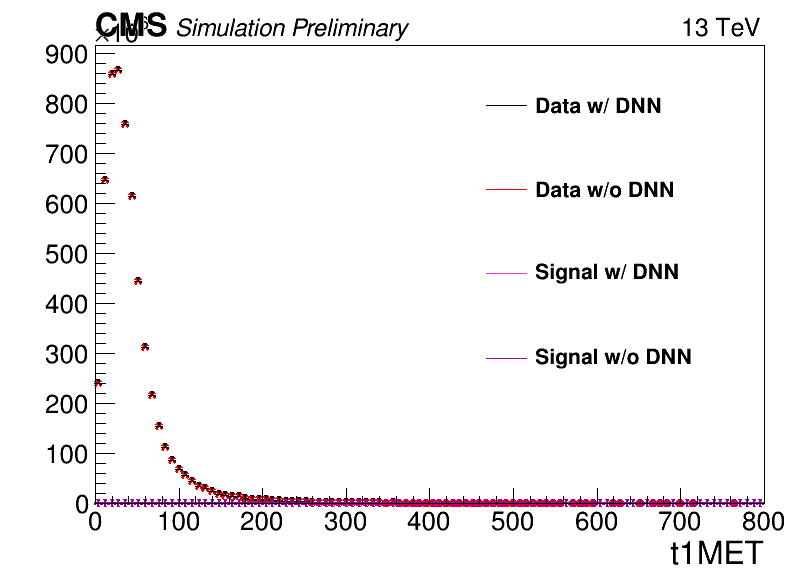

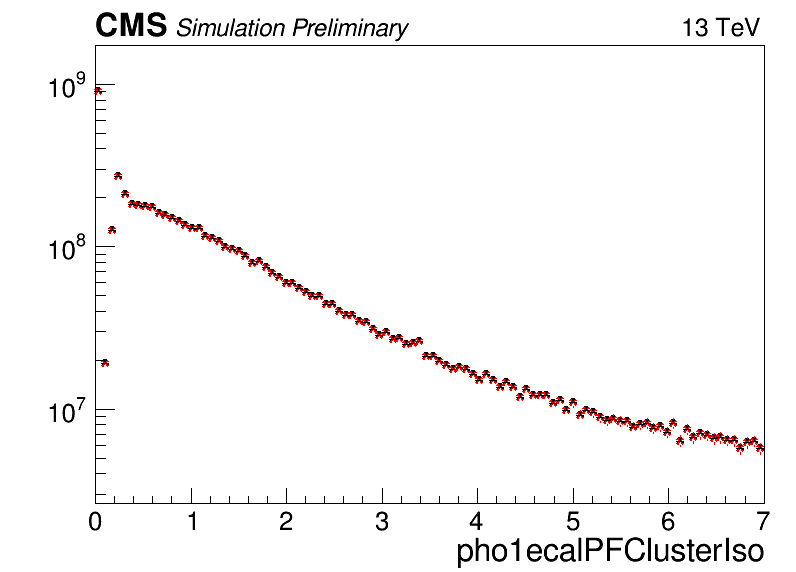

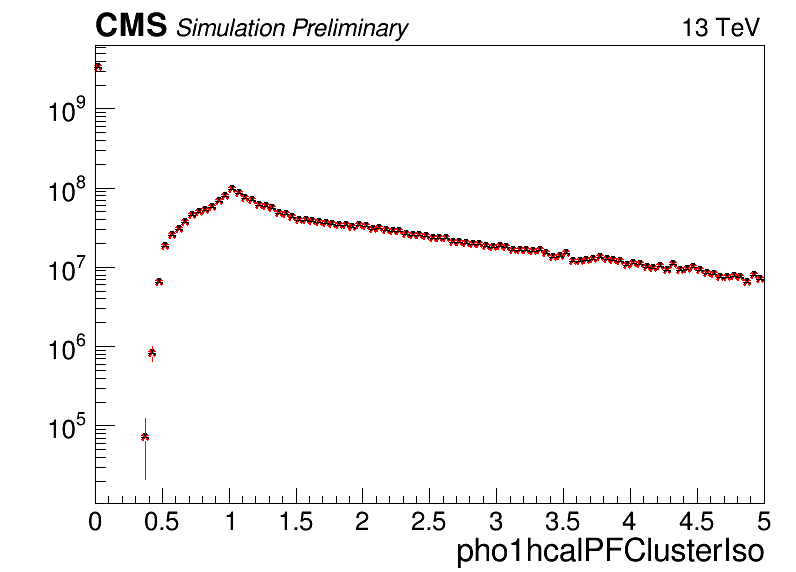

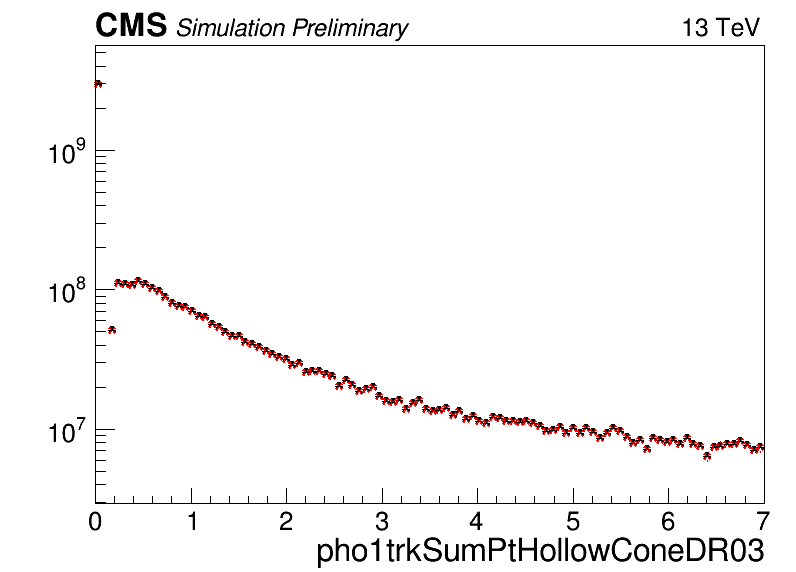

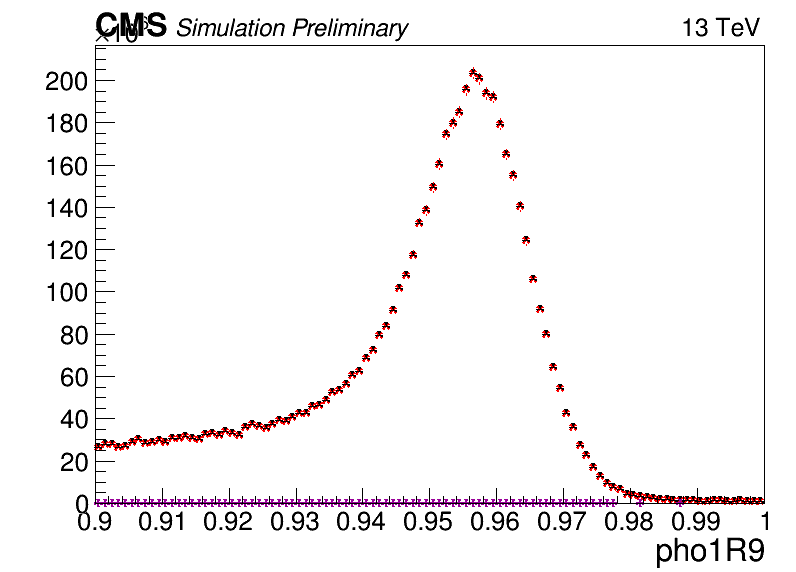

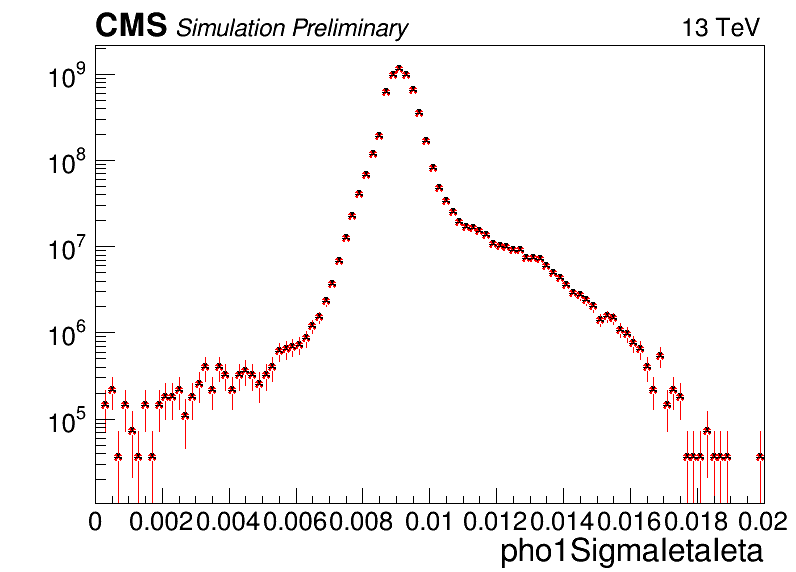

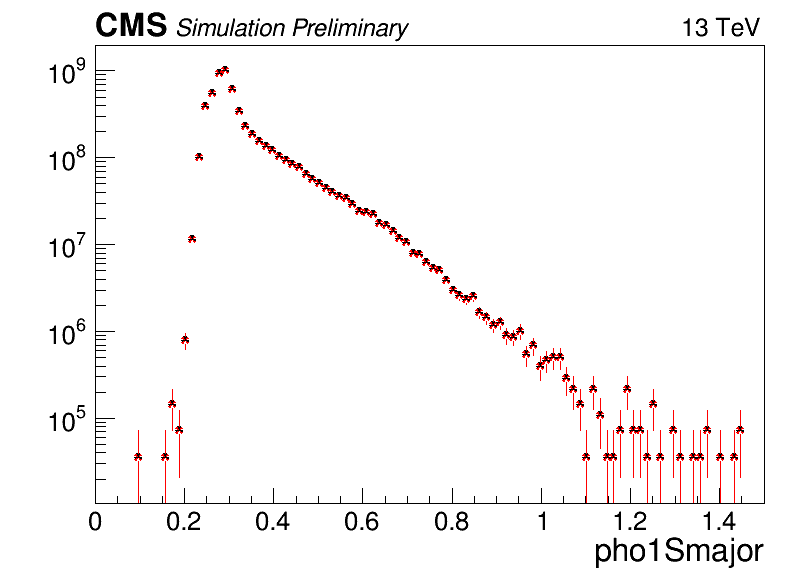

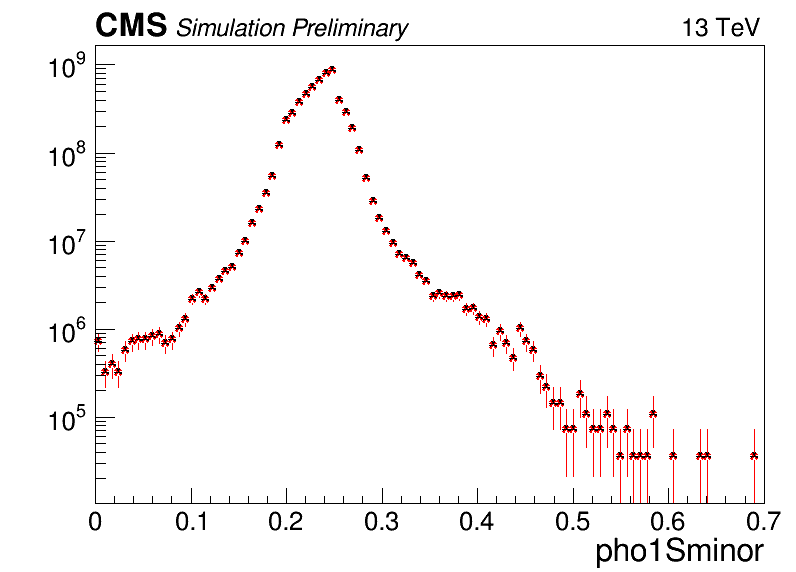

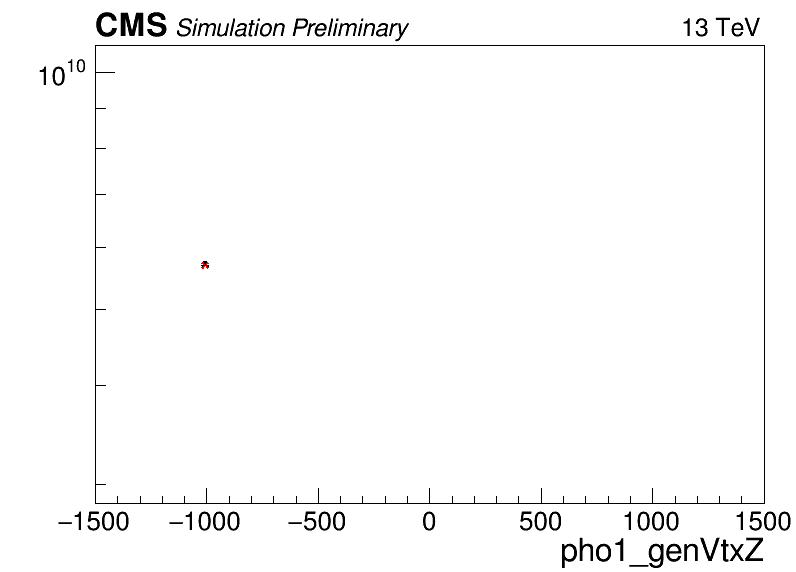

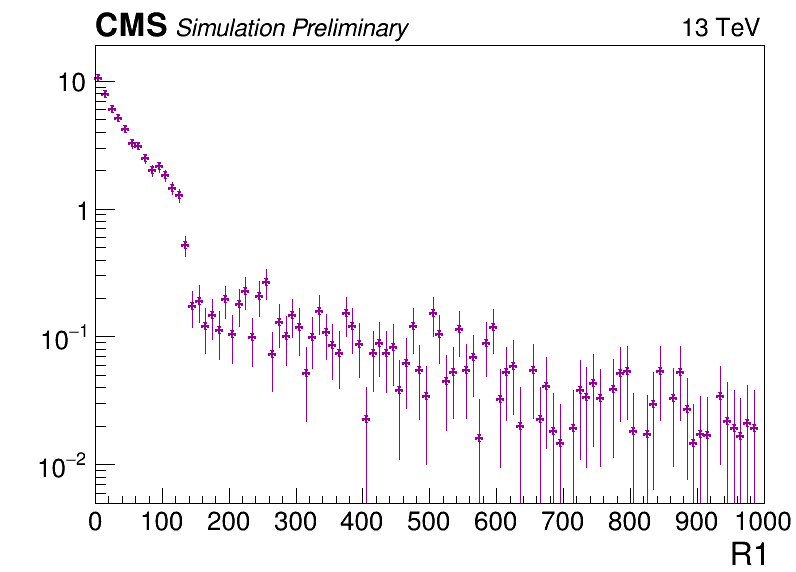

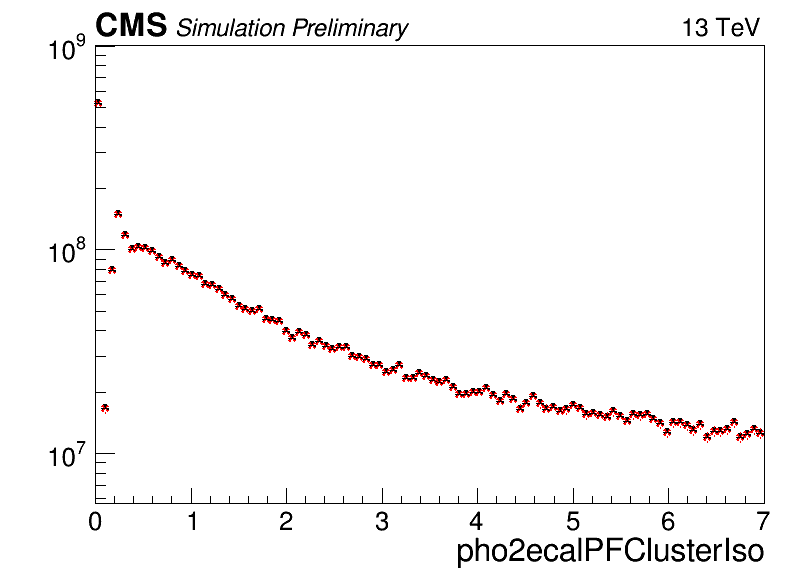

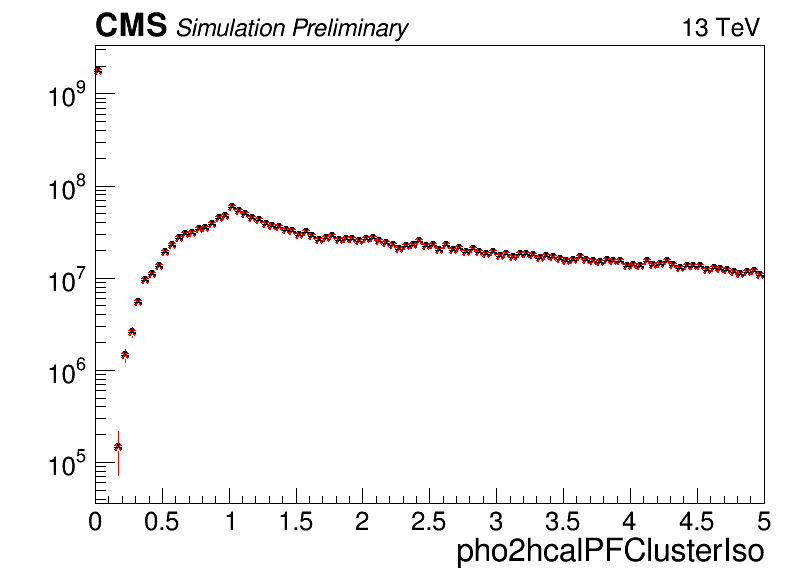

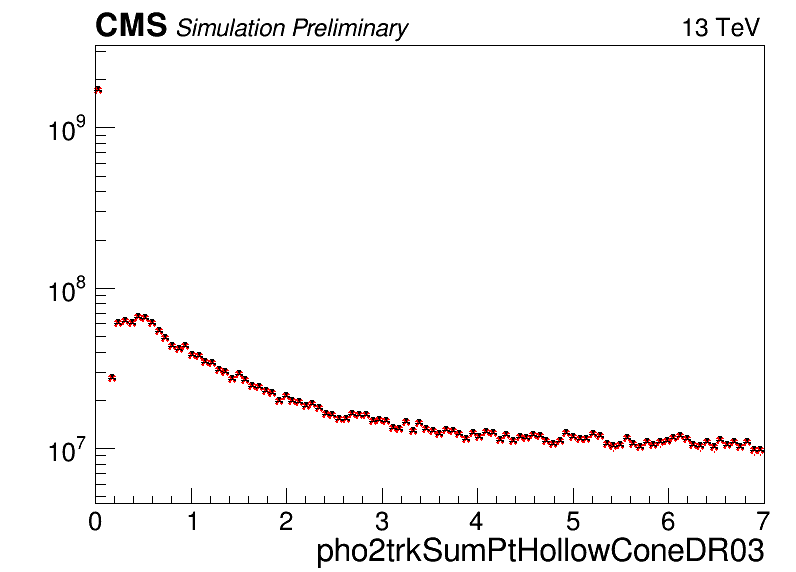

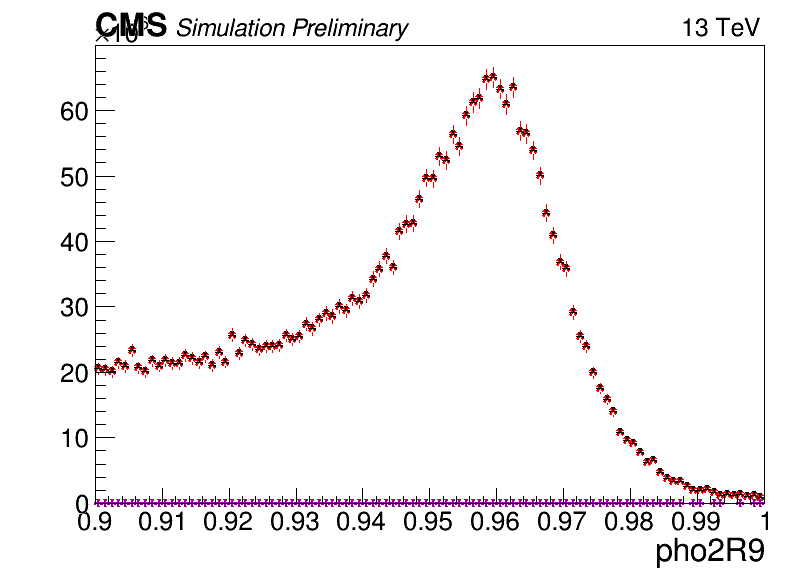

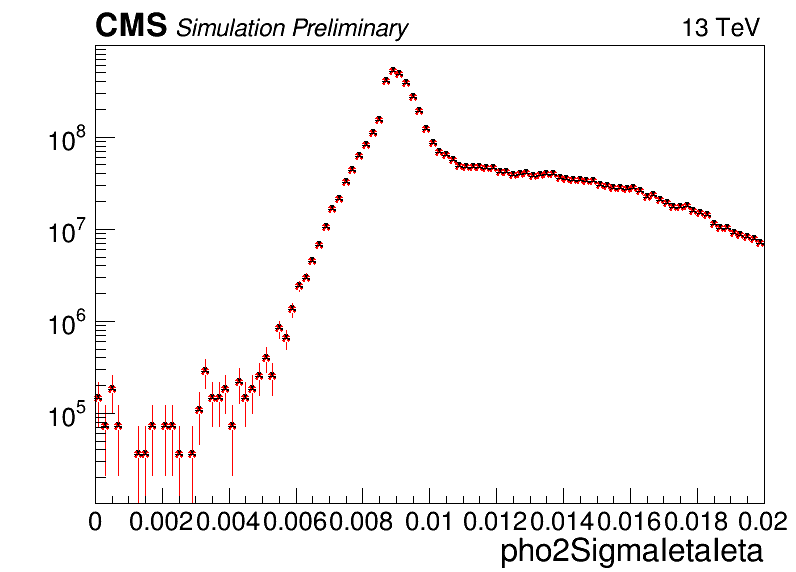

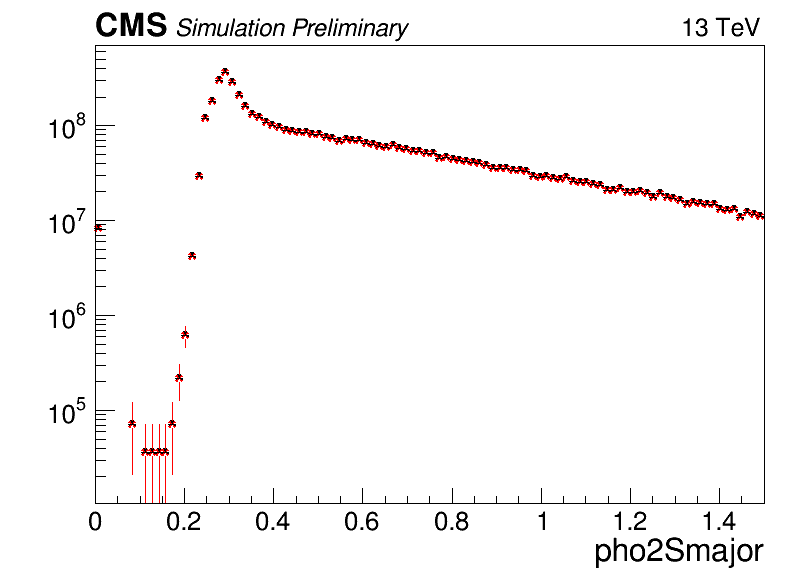

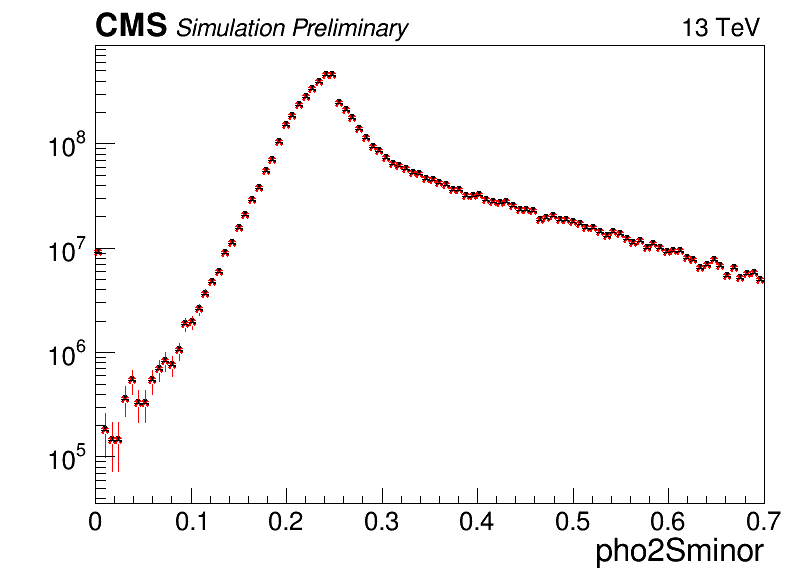

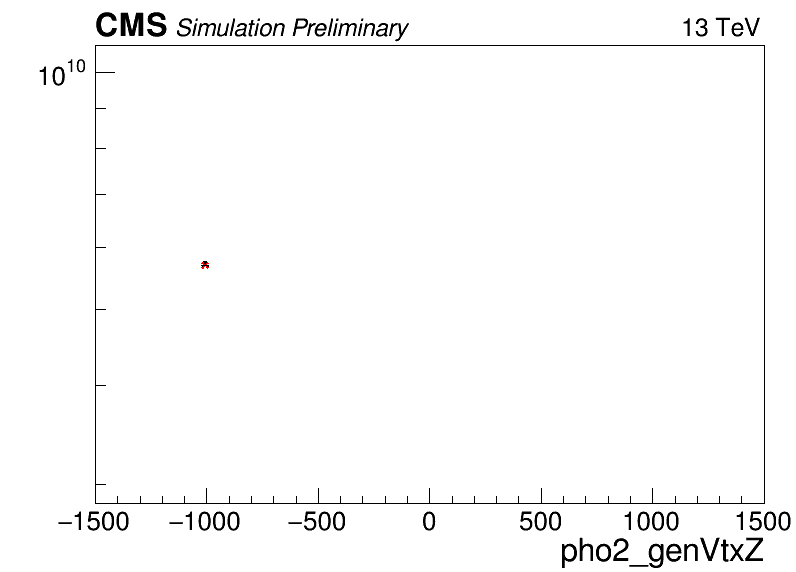

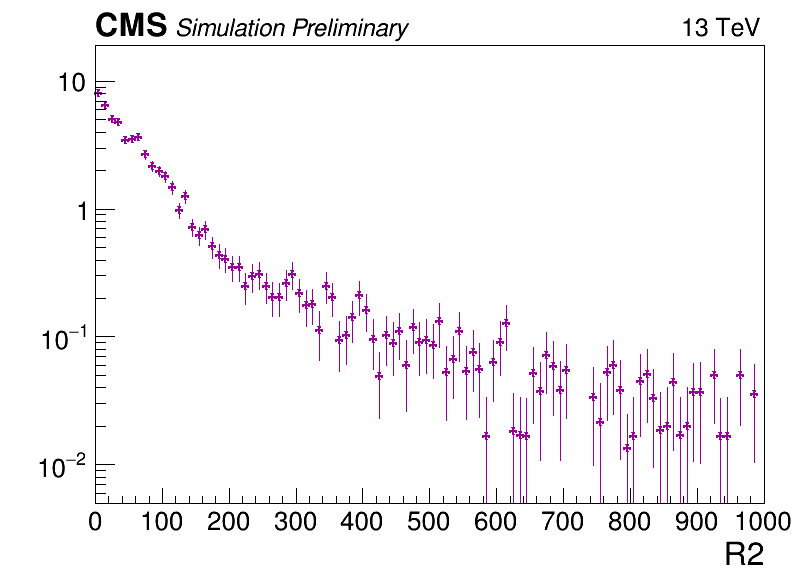

In [21]:
#### import plotLib.CMS_lumi as CMS_lumi
import plotLib.tdrstyle as tdrstyle
import plotLib.CMS_lumi as CMS_lumi

tdrstyle.setTDRStyle()

rt.gStyle.SetOptStat(0)
#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "Simulation Preliminary"
CMS_lumi.lumi_sqrtS = "13 TeV" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)

iPos = 0
if( iPos==0 ): CMS_lumi.relPosX = 0.12

H_ref = 600;
W_ref = 800;
W = W_ref
H  = H_ref
iPeriod = 0

# references for T, B, L, R
T = 0.08*H_ref
B = 0.12*H_ref
L = 0.12*W_ref
R = 0.04*W_ref


c1 = {}
leg = {}
h_dummy = {}
for i, fea in enumerate(features):
    c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
    c1[fea].cd()
    c1[fea].SetFillColor(0)
    c1[fea].SetBorderMode(0)
    c1[fea].SetFrameFillStyle(0)
    c1[fea].SetFrameBorderMode(0)
    c1[fea].SetLeftMargin( L/W )
    c1[fea].SetRightMargin( R/W )
    c1[fea].SetTopMargin( T/H )
    c1[fea].SetBottomMargin( B/H )
    c1[fea].SetTickx(0)
    c1[fea].SetTicky(0)
    rt.gStyle.SetOptStat(0)
#     h_dummy[fea] = signal_hist[fea].Clone("dummy{}".format(fea));
#     h_dummy[fea].SetTitle("")
#     h_dummy[fea].SetLineColor(0);
#     h_dummy[fea].SetFillColor(0);
#     h_dummy[fea].SetMarkerColor(0)
#     h_dummy[fea].GetYaxis().SetTitleOffset(1.1)
#     h_dummy[fea].SetDirectory(0)
#     # Get max Y
#     hsum = hstack[fea].GetStack().Last()
#     maxY = max([hsum.GetMaximum(), signal_hist[fea].GetMaximum(), allsn_hist[fea].GetMaximum()])
#     h_dummy[fea].SetAxisRange(1e-1,maxY*1.3,"Y")
#     h_dummy[fea].Draw()

#     hstack[fea].Draw("hist same")
#     hstack[fea].SetName("")
#     hstack[fea].GetXaxis().SetTitle(fea)
#     hstack[fea].GetXaxis().SetTitleSize(0.05)
    
    for hist in hist_list[fea]:
        #hist.Scale(1./hist.Integral())
        hist.Draw("L same")
        
#     allsn_hist[fea].Scale(1./allsn_hist[fea].Integral())
#     allsn_hist[fea].Draw("L same")
        
    if useLogY[fea]:
        rt.gPad.SetLogy()
        
    rt.gStyle.SetOptStat(0)
    if i==0:
        leg[fea] = rt.TLegend(0.6,0.3,0.89,0.89)
        leg[fea].SetBorderSize(0)
        for i, hist in enumerate(hist_list[fea]):
            hist_name = hist.GetName()
            hist_lambda, hist_ctau = hist_name.split('_')[-2], hist_name.split('_')[-1]
            leg[fea].AddEntry(hist, legend_list[i], "l")
        leg[fea].Draw()
    
    c1[fea].Draw()
        
    #draw the lumi text on the c1[fea]
    CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)

    c1[fea].cd()
    c1[fea].Update()
    c1[fea].RedrawAxis()
    frame = c1[fea].GetFrame()
    frame.Draw()



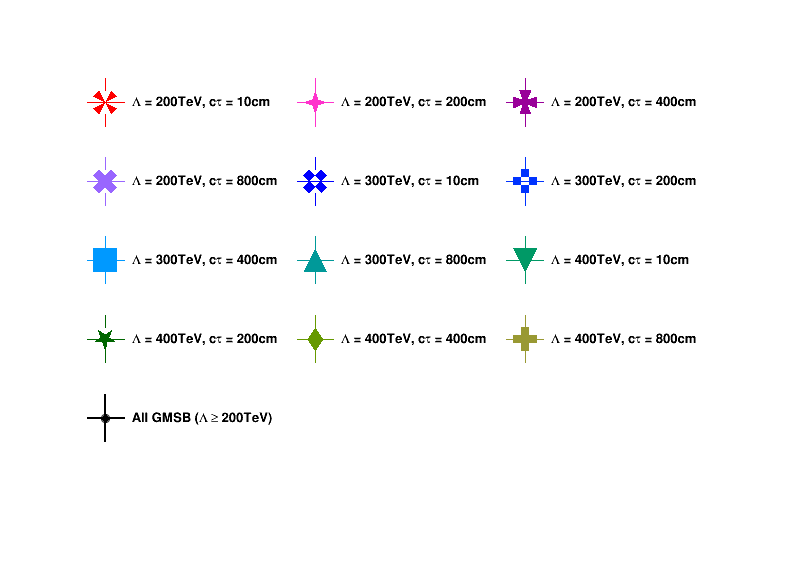

In [7]:
# Canvas for legend
rt.gStyle.SetOptStat(0)

fea = features[-1]
cleg = rt.TCanvas("cleg", "", 50, 50, W, H)
cleg.cd()
leg[fea] = rt.TLegend(0.1,0.2,0.89,0.89)
leg[fea].SetNColumns(3)
leg[fea].SetBorderSize(0)
for hist in hist_list[fea]:
    hist_name = hist.GetName()
    hist.SetMarkerSize(3)
    hist_lambda, hist_ctau = hist_name.split('_')[-2], hist_name.split('_')[-1]
    leg[fea].AddEntry(hist, "#Lambda = {}TeV, c#tau = {}cm".format(hist_lambda, hist_ctau), "lep")
leg[fea].AddEntry(allsn_hist[fea], "All GMSB (#Lambda #geq 200TeV)", 'lep')
leg[fea].Draw()
cleg.Draw()

13 TeV
13 TeV


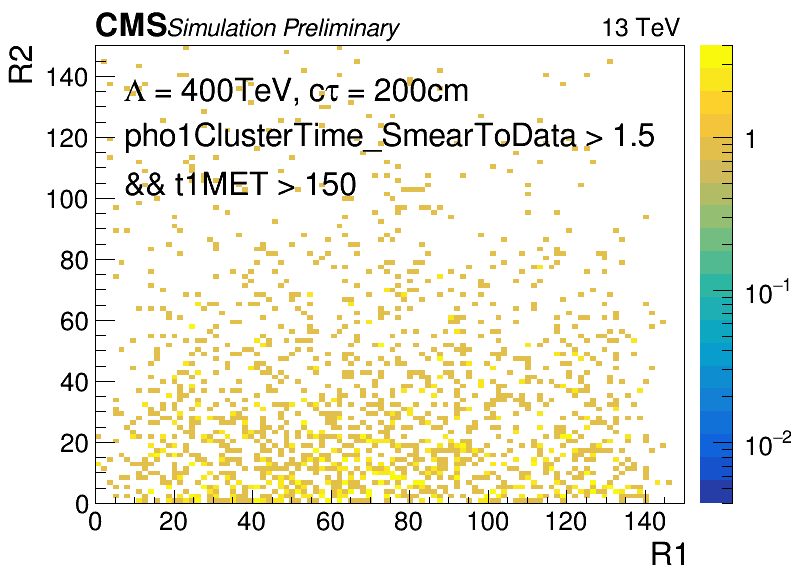

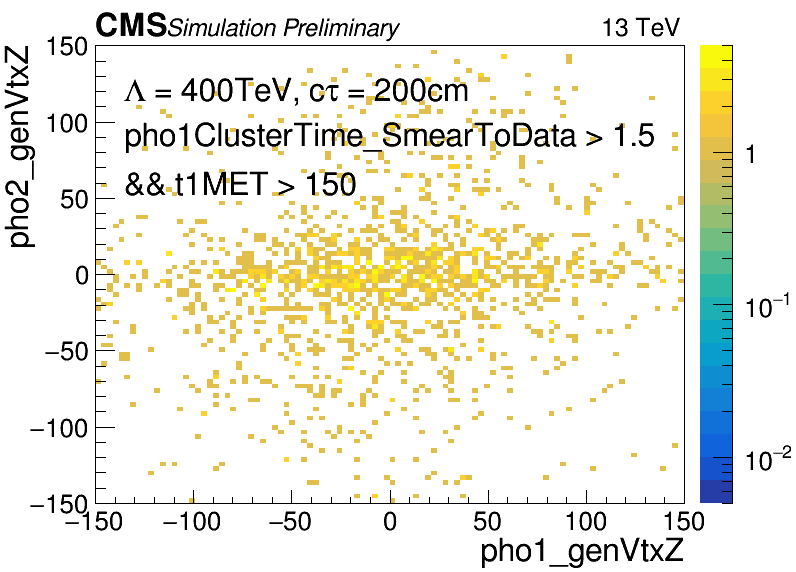

In [8]:
### 2D visualization of radius and decay Z of the 2 leading photons for low and high ctau
condition = "pho1ClusterTime_SmearToData > 1.5 && t1MET > 150"
target_lambda = 400
target_ctaus = [200]
radius = {}
decayZ = {}
for target_ctau in target_ctaus:
    for sample in filelist:
        ### Get lambda and ctau 
        this_lambda, this_ctau = extract_num(sample)
        if int(this_lambda) == target_lambda and int(this_ctau) == target_ctau:
            tmp_file = rt.TFile.Open(sample, "READ")
            tmp_tree = tmp_file.Get("DelayedPhoton")

            radius[target_ctau] = rt.TH2F("radius_{}_{}".format(target_lambda, target_ctau),
                             ";R1;R2", 100, 0, 150, 100, 0, 150)
            tmp_tree.Draw("R2:R1 >> radius_{}_{}".format(target_lambda, target_ctau), condition)
            radius[target_ctau].SetDirectory(0)
            
            decayZ[target_ctau] = rt.TH2F("decayZ_{}_{}".format(target_lambda, target_ctau),
                            ";pho1_genVtxZ; pho2_genVtxZ", 100, -150, 150, 100, -150, 150)
            tmp_tree.Draw("pho2_genVtxZ:pho1_genVtxZ >> decayZ_{}_{}".format(target_lambda, target_ctau), condition)
            decayZ[target_ctau].SetDirectory(0)
            tmp_file.Close()
            
plot2D = [radius, decayZ]

# Position of the text

for target_ctau in target_ctaus:
    for plot in plot2D:
        fea = np.random.randint(100)
        c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
        c1[fea].cd()
        c1[fea].SetFillColor(0)
        c1[fea].SetBorderMode(0)
        c1[fea].SetFrameFillStyle(0)
        c1[fea].SetFrameBorderMode(0)
        c1[fea].SetLeftMargin( L/W )
        c1[fea].SetRightMargin( R/W +0.1)
        c1[fea].SetTopMargin( T/H )
        c1[fea].SetBottomMargin( B/H )
        c1[fea].SetTickx(0)
        c1[fea].SetTicky(0)
        rt.gStyle.SetOptStat(0)
        plot[target_ctau].GetYaxis().SetTitleOffset(1.0)
        plot[target_ctau].Draw("COLZ")
        rt.gPad.SetLogz()
        rt.gStyle.SetOptStat(0)
        c1[fea].Draw()

        #draw the lumi text on the c1[fea]
        CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)

        c1[fea].cd()
        c1[fea].Update()
        c1[fea].RedrawAxis()
        frame = c1[fea].GetFrame()
        frame.Draw()

        # Add text 
        latex = rt.TLatex()
        latex.SetTextFont(42)
        latex.SetTextAngle(0)
        latex.SetTextColor(rt.kBlack)
        latex.SetTextSize(0.06)
        latex.SetTextAlign(12)
        xpos = plot[target_ctau].GetXaxis().GetXmin()+0.05*(plot[target_ctau].GetXaxis().GetXmax()-plot[target_ctau].GetXaxis().GetXmin())
        ypos = plot[target_ctau].GetYaxis().GetXmin()+0.9*(plot[target_ctau].GetYaxis().GetXmax()-plot[target_ctau].GetYaxis().GetXmin())
        ypos2 = plot[target_ctau].GetYaxis().GetXmin()+0.8*(plot[target_ctau].GetYaxis().GetXmax()-plot[target_ctau].GetYaxis().GetXmin())
        ypos3 = plot[target_ctau].GetYaxis().GetXmin()+0.7*(plot[target_ctau].GetYaxis().GetXmax()-plot[target_ctau].GetYaxis().GetXmin())

        latex.DrawLatex(xpos, ypos,"#Lambda = {}TeV, c#tau = {}cm".format(target_lambda, target_ctau))
        latex.DrawLatex(xpos, ypos2, "pho1ClusterTime_SmearToData > 1.5")
        latex.DrawLatex(xpos, ypos3, "&& t1MET > 150")

        c1[fea].Update()
        
        # Move color palette
        palette = plot[target_ctau].GetListOfFunctions().FindObject("palette")
        palette.SetX1NDC(0.88);
        palette.SetX2NDC(0.92);
        rt.gPad.Modified();
        rt.gPad.Update()

13 TeV


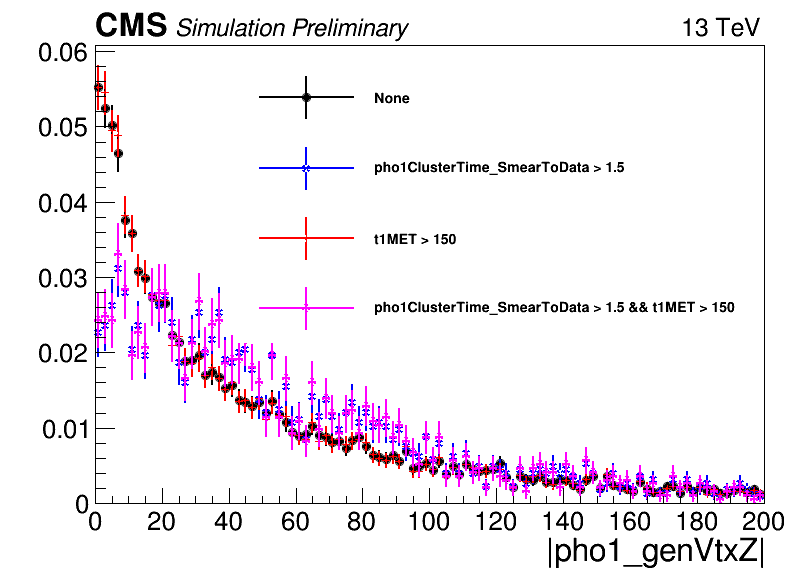

In [9]:
### 1D visualization of R2 before and after the cuts
time_cut = "pho1ClusterTime_SmearToData > 1.5"
met_cut = "t1MET > 150"



colors = [rt.kBlack, rt.kBlue, rt.kRed, rt.kMagenta]
cuts = ["", time_cut, met_cut, time_cut+" && "+met_cut]
target_lambda = 400
target_ctaus = [200]
radius = {}
decayZ = {}


for target_ctau in target_ctaus:
    for sample in filelist:
        ### Get lambda and ctau 
        this_lambda, this_ctau = extract_num(sample)
        if int(this_lambda) == target_lambda and int(this_ctau) == target_ctau:
            tmp_file = rt.TFile.Open(sample, "READ")
            tmp_tree = tmp_file.Get("DelayedPhoton")
            for i, cut in enumerate(cuts):
                radius[cut] = rt.TH1F("pho1_genVtxZ_{}".format(cut),
                                 ";|pho1_genVtxZ|", 100, 0, 200)
                tmp_tree.Draw("abs(pho1_genVtxZ) >> pho1_genVtxZ_{}".format(cut), cut)
                radius[cut].SetDirectory(0)
                radius[cut].Scale(1./radius[cut].Integral())
                radius[cut].SetLineWidth(2)
                radius[cut].SetLineColor(colors[i])
                radius[cut].SetMarkerColor(colors[i])
                radius[cut].SetMarkerStyle(sample_marker[i])
                if i==0: radius[cut].SetMarkerStyle(20)

            tmp_file.Close()
            
fea = '1D'
c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
c1[fea].cd()
c1[fea].SetFillColor(0)
c1[fea].SetBorderMode(0)
c1[fea].SetFrameFillStyle(0)
c1[fea].SetFrameBorderMode(0)
c1[fea].SetLeftMargin( L/W )
c1[fea].SetRightMargin( R/W )
c1[fea].SetTopMargin( T/H )
c1[fea].SetBottomMargin( B/H )
c1[fea].SetTickx(0)
c1[fea].SetTicky(0)
rt.gStyle.SetOptStat(0)
for cut in cuts:
    radius[cut].Draw("l same")
#rt.gPad.SetLogz()
rt.gStyle.SetOptStat(0)
c1[fea].Draw()

leg[fea] = rt.TLegend(0.3,0.4,0.98,0.89)
leg[fea].SetBorderSize(0)
for cut in cuts:
    radius[cut].SetMarkerSize(1)
    leg[fea].AddEntry(radius[cut], "{}".format(cut) if cut!="" else "None", "lep")
leg[fea].Draw()

#draw the lumi text on the c1[fea]
CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)

c1[fea].cd()
c1[fea].Update()
c1[fea].RedrawAxis()
frame = c1[fea].GetFrame()
frame.Draw()




13 TeV


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[1D]


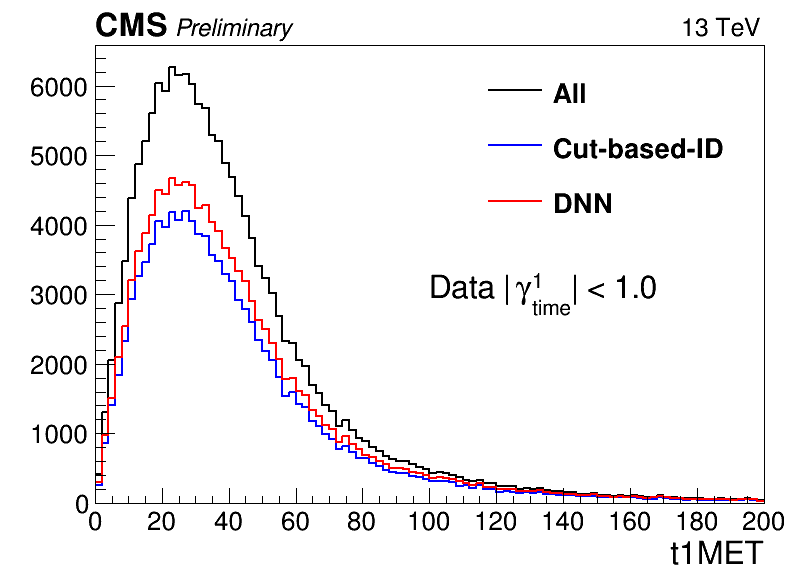

In [45]:
### 1D visualization of R2 before and after the cuts

data_DNN = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/DelayedPhoton_DoubleEG_2016All_GoodLumi.root'
signal_DNN = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/GMSB_L200TeV_Ctau200cm_13TeV-pythia8.root'

data_list = [data_DNN]#, signal_DNN]

event_cut = 'n_Jets > 2 && (HLTDecision[81] == 1) && \
             n_Photons == 2 && \
             abs(pho1ClusterTime_SmearToData) < 1.0'

pho_cut = ' && pho1Pt > 50 && abs(pho1Eta)<1.4442 \
            && abs(pho1HoverE) < 0.08 \
            && pho1R9 > 0.9 && abs(pho1SigmaIetaIeta) < 0.020 \
            && abs(pho1ecalPFClusterIso) < 7.0 \
            && abs(pho1hcalPFClusterIso) < 5.0 \
            && abs(pho1trkSumPtHollowConeDR03) < 7.0'

met_cut = " && Flag_HBHENoiseFilter == 1 && Flag_HBHEIsoNoiseFilter ==1 && \
       Flag_goodVertices == 1 && Flag_eeBadScFilter == 1 && \
       Flag_EcalDeadCellTriggerPrimitiveFilter == 1 && \
       Flag_CSCTightHaloFilter == 1  && \
       Flag_badMuonFilter == 1 && Flag_badGlobalMuonFilter == 0 && \
       Flag_duplicateMuonFilter == 0 "

comb_cut = event_cut + pho_cut + met_cut

colors = [rt.kBlack, rt.kBlue, rt.kRed, rt.kMagenta]

cuts = [comb_cut, comb_cut + "&& pho1passIsoTight_comboIso", comb_cut + "&& (pho1DNN > 0.2312)"]

cutName = ['All', 'Cut-based-ID', 'DNN']

target_lambda = 200
target_ctaus = [200]
radius = {}
decayZ = {}
for sample in data_list:
        ### Get lambda and ctau 
    if 'GMSB' in sample: 
        this_lambda, this_ctau = extract_num(sample)
    #if int(this_lambda) == target_lambda and int(this_ctau) == target_ctau:
    tmp_file = rt.TFile.Open(sample, "READ")
    tmp_tree = tmp_file.Get("DelayedPhoton")
    for i, cut in enumerate(cuts):
        radius[cut] = rt.TH1F("t1MET_{}".format(cutName[i]),
                         ";t1MET", 100, 0, 200)
        tmp_tree.Draw("t1MET >> t1MET_{}".format(cutName[i]), cut)
        radius[cut].SetDirectory(0)
        #radius[cut].Scale(1./radius[cut].Integral())
        radius[cut].SetLineWidth(2)
        radius[cut].SetLineColor(colors[i])
        radius[cut].SetMarkerColor(colors[i])
        radius[cut].SetMarkerStyle(sample_marker[i])
        if i==0: radius[cut].SetMarkerStyle(20)

    tmp_file.Close()
            
fea = '1D'
c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
c1[fea].cd()
c1[fea].SetFillColor(0)
c1[fea].SetBorderMode(0)
c1[fea].SetFrameFillStyle(0)
c1[fea].SetFrameBorderMode(0)
c1[fea].SetLeftMargin( L/W )
c1[fea].SetRightMargin( R/W )
c1[fea].SetTopMargin( T/H )
c1[fea].SetBottomMargin( B/H )
c1[fea].SetTickx(0)
c1[fea].SetTicky(0)
rt.gStyle.SetOptStat(0)
for cut in cuts:
    radius[cut].Draw("same")
#rt.gPad.SetLogz()
rt.gStyle.SetOptStat(0)
c1[fea].Draw()

leg[fea] = rt.TLegend(0.6,0.6,0.98,0.89)
leg[fea].SetBorderSize(0)
for i, cut in enumerate(cuts):
    radius[cut].SetMarkerSize(1)
    leg[fea].AddEntry(radius[cut], "{}".format(cutName[i]) if cut!="" else "None", "l")
leg[fea].Draw()

#draw the lumi text on the c1[fea]
latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.06)
latex.SetTextAlign(12)
CMS_lumi.extraText = "Preliminary"
CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)
xpos = 100
ypos = 3000
latex.DrawLatex(xpos, ypos,"Data | #gamma^{1}_{time}| < 1.0")

c1[fea].cd()
c1[fea].Update()
c1[fea].RedrawAxis()
frame = c1[fea].GetFrame()
frame.Draw()




13 TeV
13 TeV


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1[1D]


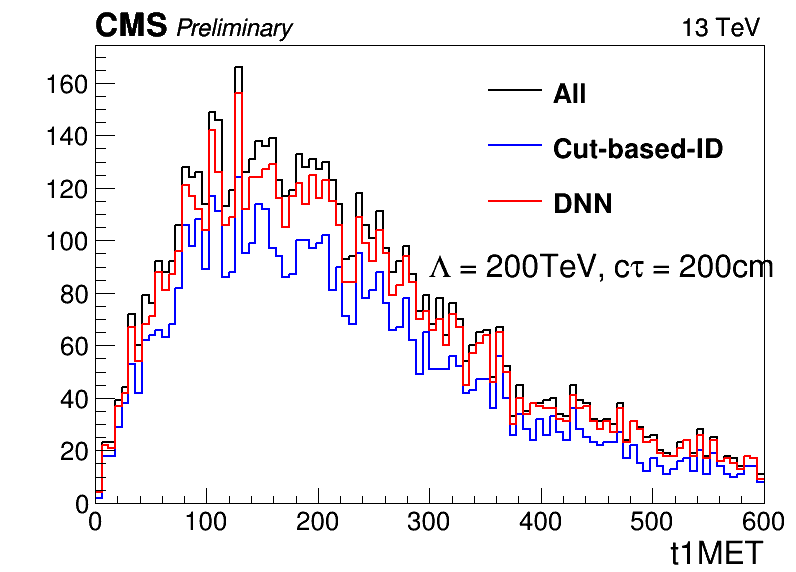

In [48]:
### 1D visualization of R2 before and after the cuts

data_DNN = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/DelayedPhoton_DoubleEG_2016All_GoodLumi.root'
signal_DNN = '/storage/user/qnguyen/DelayedPhoton/CMSSW_10_6_6/src/DelayedPhotonID/deployment/output/GMSB_L200TeV_Ctau200cm_13TeV-pythia8.root'

data_list = [signal_DNN]

event_cut = 'n_Jets > 2 && (HLTDecision[81] == 1) && \
             n_Photons == 2'

pho_cut = ' && pho1Pt > 50 && abs(pho1Eta)<1.4442 \
            && abs(pho1HoverE) < 0.08 \
            && pho1R9 > 0.9 && abs(pho1SigmaIetaIeta) < 0.020 \
            && abs(pho1ecalPFClusterIso) < 7.0 \
            && abs(pho1hcalPFClusterIso) < 5.0 \
            && abs(pho1trkSumPtHollowConeDR03) < 7.0'

met_cut = " && Flag_HBHENoiseFilter == 1 && Flag_HBHEIsoNoiseFilter ==1 && \
       Flag_goodVertices == 1 && Flag_eeBadScFilter == 1 && \
       Flag_EcalDeadCellTriggerPrimitiveFilter == 1 && \
       Flag_CSCTightHaloFilter == 1  && \
       Flag_badMuonFilter == 1 && Flag_badGlobalMuonFilter == 0 && \
       Flag_duplicateMuonFilter == 0 "

comb_cut = event_cut + pho_cut + met_cut

colors = [rt.kBlack, rt.kBlue, rt.kRed, rt.kMagenta]

cuts = [comb_cut, comb_cut + "&& pho1passIsoTight_comboIso", comb_cut + "&& (pho1DNN > 0.2312)"]

cutName = ['All', 'Cut-based-ID', 'DNN']

target_lambda = 200
target_ctaus = [200]
radius = {}
decayZ = {}
for sample in data_list:
        ### Get lambda and ctau 
    if 'GMSB' in sample: 
        this_lambda, this_ctau = extract_num(sample)
    #if int(this_lambda) == target_lambda and int(this_ctau) == target_ctau:
    tmp_file = rt.TFile.Open(sample, "READ")
    tmp_tree = tmp_file.Get("DelayedPhoton")
    for i, cut in enumerate(cuts):
        radius[cut] = rt.TH1F("t1MET_{}".format(cutName[i]),
                         ";t1MET", 100, 0, 600)
        tmp_tree.Draw("t1MET >> t1MET_{}".format(cutName[i]), cut)
        radius[cut].SetDirectory(0)
        #radius[cut].Scale(1./radius[cut].Integral())
        radius[cut].SetLineWidth(2)
        radius[cut].SetLineColor(colors[i])
        radius[cut].SetMarkerColor(colors[i])
        radius[cut].SetMarkerStyle(sample_marker[i])
        if i==0: radius[cut].SetMarkerStyle(20)

    tmp_file.Close()
            
fea = '1D'
c1[fea] = rt.TCanvas("c1[{}]".format(fea),"",50, 50, W, H)
c1[fea].cd()
c1[fea].SetFillColor(0)
c1[fea].SetBorderMode(0)
c1[fea].SetFrameFillStyle(0)
c1[fea].SetFrameBorderMode(0)
c1[fea].SetLeftMargin( L/W )
c1[fea].SetRightMargin( R/W )
c1[fea].SetTopMargin( T/H )
c1[fea].SetBottomMargin( B/H )
c1[fea].SetTickx(0)
c1[fea].SetTicky(0)
rt.gStyle.SetOptStat(0)
for cut in cuts:
    radius[cut].Draw("same")
#rt.gPad.SetLogz()
rt.gStyle.SetOptStat(0)
c1[fea].Draw()

leg[fea] = rt.TLegend(0.6,0.6,0.98,0.89)
leg[fea].SetBorderSize(0)
for i, cut in enumerate(cuts):
    radius[cut].SetMarkerSize(1)
    leg[fea].AddEntry(radius[cut], "{}".format(cutName[i]) if cut!="" else "None", "l")
leg[fea].Draw()


latex = rt.TLatex()
latex.SetTextFont(42)
latex.SetTextAngle(0)
latex.SetTextColor(rt.kBlack)
latex.SetTextSize(0.06)
latex.SetTextAlign(12)
CMS_lumi.extraText = "Preliminary"
CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)
xpos = 300
ypos = 90
latex.DrawLatex(xpos, ypos,"#Lambda = 200TeV, c#tau = 200cm")

#draw the lumi text on the c1[fea]
CMS_lumi.CMS_lumi(c1[fea], iPeriod, iPos)
CMS_lumi.extraText = "Simulation Preliminary"

c1[fea].cd()
c1[fea].Update()
c1[fea].RedrawAxis()
frame = c1[fea].GetFrame()
frame.Draw()


